# install stuff

In [1]:
! pip install pyspark pandas scikit-learn langdetect 

     |████████████████████████████████| 212.4MB 64kB/s 
     |████████████████████████████████| 983kB 16.1MB/s 
     |████████████████████████████████| 204kB 51.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=45be440a7ced8ef1a242042f0fbe8a10e1526bf7e9ce75120ed7bacf1f1c0d52
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=50ac7ae248fdae9464c02891fd0c5924b7ac716f57ce38621e18c69730f7c45d
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built pyspark langdetect


# setup pyspark

In [2]:
import pyspark.sql
from pyspark.sql import functions as sf
import pyspark
from langdetect import detect
from pyspark.sql.window import Window

In [3]:
! gdown https://drive.google.com/uc?id=1ORCn-Mbs4-peTkaS519XgAfTR4sR7mHm # Спасибо Денису Штырову, который загрузил на свой диск архив
# Это сделано для того, чтобы все работа через RunAll

Downloading...
From: https://drive.google.com/uc?id=1ORCn-Mbs4-peTkaS519XgAfTR4sR7mHm
To: /content/hw_data.zip
763MB [00:05, 128MB/s]


In [4]:
!unzip -q ./hw_data.zip -d ./ 

In [5]:
sparkConf = pyspark.SparkConf() \
    .set("spark.executor.memory", "512m")\
    .set("spark.driver.memory", "512m")
ss = pyspark.sql.SparkSession.builder.config(conf=sparkConf).master('local[1]').getOrCreate()

# load data

In [6]:
train_data = ss.read.orc('./posts_train.orc')
test_data = ss.read.orc('./posts_test.orc')
channel_data = ss.read.orc('./channels_orc')

In [7]:
channel_data.show()

+--------------------+----------+--------------------+----------------+----------+----------+--------------------+--------------------+----------+----------+
|         description|is_private|         last_parsed|            name|post_count|     tg_id|               title|             updated|user_count|channel_id|
+--------------------+----------+--------------------+----------------+----------+----------+--------------------+--------------------+----------+----------+
|                    |     false|2019-01-26 16:53:...|   MoeinZchannel|     708.0|1002972402|             Moein Z|2019-01-26 16:53:...|   62411.0|      7910|
|Вокруг столько ме...|     false|2019-02-12 00:39:...|  merzotachannel|    1027.0|1336284461|            Мерзость|2019-02-12 00:39:...|   12982.0|     14121|
|🗣እኛስ የተሰቀለውን ክርስ...|     false|2019-02-10 06:57:...|christian_mezmur|    1168.0|1136987361|Christian Mezmur ...|2019-02-10 06:57:...|   21704.0|     17375|
|     Chiroyli_qomatt|     false|2018-12-08 00:54:...

# make features

In [8]:
@sf.udf
def text_len(text):
  if text == None: 
    return 0
  return len(text)

In [9]:
@sf.udf
def text_lang(text):
  try:
    return detect(text)
  except:
    return 'hard to detect'

In [10]:
train_data = train_data.withColumn('text_size', text_len("text").cast('int'))

In [11]:
timeFmt = "yyyy-MM-dd HH:mm:ss+SS"
train_data = train_data.join(channel_data.select(["channel_id", 'updated']), on='channel_id', how='left')\
            .withColumn('time_passed', sf.unix_timestamp('updated', format=timeFmt) - sf.unix_timestamp('date', format=timeFmt) / 360) # сколько прошло времени с момента поста в минутах

In [12]:
ws = Window.partitionBy('channel_id') \
          .orderBy('date_as_int') \
          .rangeBetween(-7, 0)


train_data = train_data.withColumn('date_as_int', sf.unix_timestamp(sf.col('date').cast('date')) / 86400)\
               .withColumn('average_text_len_7_days', sf.mean(sf.col('text_size')).over(ws))

In [13]:
train_data = train_data.withColumn('date_as_int', sf.unix_timestamp(sf.col('date').cast('date')) / 86400)\
             .withColumn('text_len_diff_with_mean', sf.col('average_text_len_7_days') - sf.col('text_size')) # смотрим разницу со средним количеством

In [14]:
train_data = train_data.withColumn('date_as_int', sf.unix_timestamp(sf.col('date').cast('date')) / 86400)\
             .withColumn('posts_count', sf.count('id').over(ws)) # смотрим активность канала - количество постов за неделю

In [15]:
test_data = test_data.withColumn('text_size', text_len("text").cast('int'))

In [16]:
timeFmt = "yyyy-MM-dd HH:mm:ss+SS"
test_data = test_data.join(channel_data.select(["channel_id", 'updated']), on='channel_id', how='left')\
            .withColumn('time_passed', sf.unix_timestamp('updated', format=timeFmt) - sf.unix_timestamp('date', format=timeFmt) / 360) # сколько прошло времени с момента поста в минутах

In [17]:
ws = Window.partitionBy('channel_id') \
          .orderBy('date_as_int') \
          .rangeBetween(-7, 0)


test_data = test_data.withColumn('date_as_int', sf.unix_timestamp(sf.col('date').cast('date')) / 86400)\
               .withColumn('average_text_len_7_days', sf.mean(sf.col('text_size')).over(ws))

In [18]:
test_data = test_data.withColumn('date_as_int', sf.unix_timestamp(sf.col('date').cast('date')) / 86400)\
             .withColumn('text_len_diff_with_mean', sf.col('average_text_len_7_days') - sf.col('text_size')) # смотрим разницу со средним количеством

In [19]:
test_data = test_data.withColumn('date_as_int', sf.unix_timestamp(sf.col('date').cast('date')) / 86400)\
             .withColumn('posts_count', sf.count('id').over(ws)) # смотрим активность канала - количество постов за неделю

In [20]:
def make_features(df):
    cols = ['id', 'channel_id', 'has_image', 'is_forwarded', 'forwarded_id', 'text_size', 'time_passed', 'date_as_int', 
            'average_text_len_7_days', 'text_len_diff_with_mean', 'posts_count']
    if 'views' in df.columns:
        cols.append('views')
    return df.select(*cols)

In [21]:
train_features = make_features(train_data).cache()
test_features = make_features(test_data).cache()

In [22]:
test_features.write.csv('test_csv', mode='overwrite', header=True)
train_features.write.csv('train_csv', mode='overwrite', header=True)

# load features to pandas
you also can use .toPandas()

In [23]:
import subprocess
import glob
import os
import shutil
import pandas as pd

def load_and_merge_csv(path, **kwargs):
    dfs = []
    for g in glob.glob(os.path.join(path, '*.csv')):
        dfs.append(pd.read_csv(g, **kwargs))
    res = pd.concat(dfs)
    res = res.set_index('id')
    return res

In [24]:
trainXY = load_and_merge_csv('train_csv')
testX = load_and_merge_csv('test_csv')

trainXY['has_image'] = (trainXY['has_image'] == 't').astype(int)
trainXY['is_forwarded'] = (trainXY['is_forwarded'] == 't').astype(int)

testX['has_image'] = (testX['has_image'] == 't').astype(int)
testX['is_forwarded'] = (testX['is_forwarded'] == 't').astype(int)

In [25]:
trainXY.dtypes

channel_id                   int64
has_image                    int64
is_forwarded                 int64
forwarded_id               float64
text_size                    int64
time_passed                float64
date_as_int                float64
average_text_len_7_days    float64
text_len_diff_with_mean    float64
posts_count                  int64
views                        int64
dtype: object

In [26]:
import numpy as np

Ycol = 'views'
to_drop = ['channel_id']
trainX, trainY = trainXY.drop(Ycol, axis=1).drop(to_drop, axis=1), trainXY[Ycol]
trainY = np.log(trainY + 100)

testX = testX.drop(to_drop, axis=1)

# train your model and predict test

In [27]:
import lightgbm as lgb 

m = lgb.LGBMRegressor()
m.fit(trainX, trainY)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

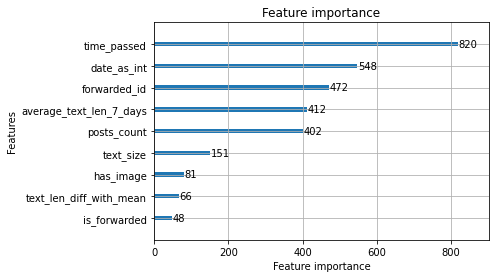

In [38]:
lgb.plot_importance(m); # Хорошие получились признаки :)

In [28]:
prediction = m.predict(testX)

In [29]:
prediction.shape

(244386,)

In [30]:
assert prediction.shape == (244386,)

# submit

In [31]:
! curl -H 'Cache-Control: no-cache' https://raw.githubusercontent.com/mike0sv/lsml_submit_server/2021/src/client.py -o client.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1906  100  1906    0     0   9076      0 --:--:-- --:--:-- --:--:--  9076


In [32]:
import client

In [33]:
client.make_eval(pd.DataFrame({'views': prediction}, index=testX.index))

Enter username:
user30
Enter password:
··········


{'data': {'mape': 10.749457292619615,
  'mean_absolute_error': 0.8346787486369379,
  'mean_squared_error': 1.3128945040077602,
  'rmse': 1.1458160864675273,
  'rmspe': 16.83697494232986},
 'ok': True}

In [34]:
client.check_results()

{'2021-06-14': [{'baseline_beaten': True,
   'is_final': False,
   'metrics': {'mape': 10.759017351746136,
    'mean_absolute_error': 0.8286153300979313,
    'mean_squared_error': 1.292552071083069,
    'rmse': 1.1369046006957086,
    'rmspe': 16.944360391174826}},
  {'baseline_beaten': True,
   'is_final': True,
   'metrics': {'mape': 10.759017351746136,
    'mean_absolute_error': 0.8286153300979313,
    'mean_squared_error': 1.292552071083069,
    'rmse': 1.1369046006957086,
    'rmspe': 16.944360391174826}},
  {'baseline_beaten': True,
   'is_final': False,
   'metrics': {'mape': 10.749457292619615,
    'mean_absolute_error': 0.8346787486369379,
    'mean_squared_error': 1.3128945040077602,
    'rmse': 1.1458160864675273,
    'rmspe': 16.83697494232986}}]}

In [ ]:
# BASELINE = {
# 	'mape': 15.707128974856676,
# 	'mean_absolute_error': 1.219070382113261,
# 	'mean_squared_error': 2.4324378881170055,
# 	'rmse': 1.5596274837655963,
# 	'rmspe': 23.50065988751091
# }